In [1]:
#  imports and load all episodes

import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import os
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from PIL import Image
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from PIL import Image


In [2]:
# 1) Create (or reuse) a local folder called "nltk_data" right next to this notebook
local_nltk = os.path.join(os.getcwd(), "nltk_data")
if not os.path.isdir(local_nltk):
    os.mkdir(local_nltk)

# 2) Prepend that local folder to NLTK’s search path
nltk.data.path.insert(0, local_nltk)

# 3) Download the needed NLTK packages into that local folder
nltk.download('punkt',      download_dir=local_nltk)
nltk.download('punkt_tab',  download_dir=local_nltk)
nltk.download('stopwords',  download_dir=local_nltk)
nltk.download('wordnet',    download_dir=local_nltk)
nltk.download('vader_lexicon', download_dir=local_nltk)

[nltk_data] Downloading package punkt to
[nltk_data]     c:\Users\woofy\Downloads\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     c:\Users\woofy\Downloads\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     c:\Users\woofy\Downloads\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     c:\Users\woofy\Downloads\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     c:\Users\woofy\Downloads\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
# file paths for each episode
files = {
    'IV': r"C:\Users\woofy\Downloads\Lab4_dataset\star_wars_movies_scripts\SW_EpisodeIV.txt",
    'V':  r"C:\Users\woofy\Downloads\Lab4_dataset\star_wars_movies_scripts\SW_EpisodeV.txt",
    'VI': r"C:\Users\woofy\Downloads\Lab4_dataset\star_wars_movies_scripts\SW_EpisodeVI.txt"
}

In [4]:
# read and combine all episodes into one dataframe
df_list = []

for ep, path in files.items():
    # read each file line by line
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()
    temp = pd.DataFrame({'raw': lines})
    # extract line number, character, and dialogue
    temp[['line_number', 'character', 'dialogue']] = temp['raw'].str.extract(r'"(\d+)"\s+"(.*?)"\s+"(.*?)"')
    temp.drop(columns=['raw'], inplace=True)
    temp.dropna(inplace=True)
    temp['line_number'] = temp['line_number'].astype(int)
    temp['episode'] = ep
    df_list.append(temp)

# combine all episodes into one dataframe
df_all = pd.concat(df_list, ignore_index=True)
df_all.head()

,line_number,character,dialogue,episode
0,1,THREEPIO,Did you hear that? They've shut down the main...,IV
1,2,THREEPIO,We're doomed!,IV
2,3,THREEPIO,There'll be no escape for the Princess this time.,IV
3,4,THREEPIO,What's that?,IV
4,5,THREEPIO,I should have known better than to trust the l...,IV


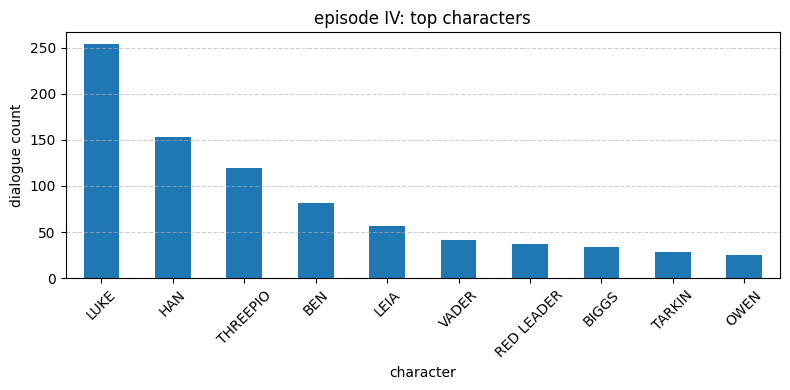

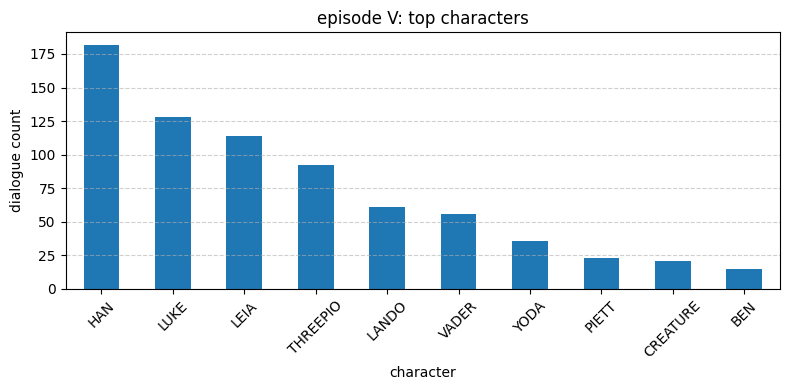

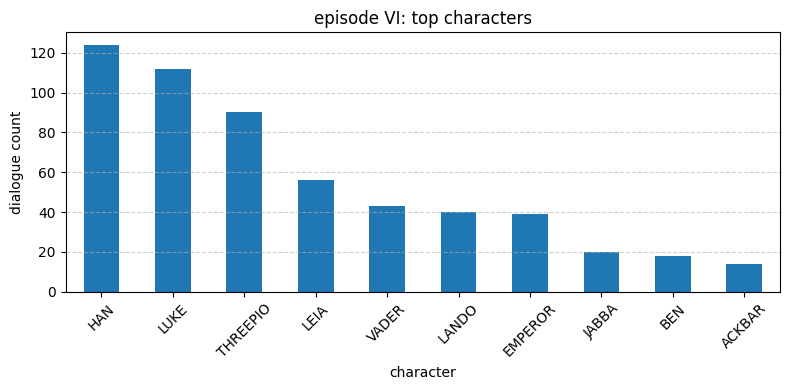

In [5]:
# cell 3: plot top 10 characters by number of dialogues for each episode

for ep in ['IV', 'V', 'VI']:
    subset = df_all[df_all['episode'] == ep]
    counts = subset['character'].value_counts().head(10)
    plt.figure(figsize=(8, 4))
    counts.plot(kind='bar')
    plt.title(f"episode {ep}: top characters")
    plt.xlabel("character")
    plt.ylabel("dialogue count")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [6]:
#  preprocess dialogues with nltk

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text.lower())
    clean = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word.isalpha() and word not in stop_words
    ]
    return clean

df_all['new_script'] = df_all['dialogue'].apply(preprocess)


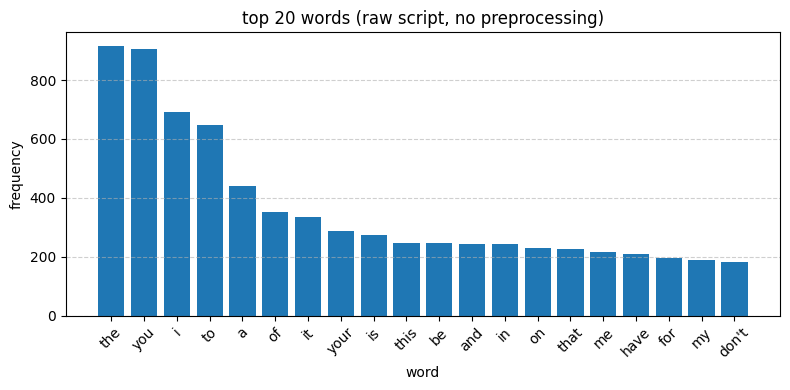

In [7]:
# tokenize raw dialogues (split on letters only, lowercase)
raw_tokens = []
for line in df_all['dialogue']:
    raw_tokens.extend(re.findall(r"[A-Za-z']+", line.lower()))

# get top 20 most common raw tokens
raw_freq = Counter(raw_tokens).most_common(20)
words_raw, counts_raw = zip(*raw_freq)

plt.figure(figsize=(8, 4))
plt.bar(words_raw, counts_raw)
plt.title("top 20 words (raw script, no preprocessing)")
plt.xlabel("word")
plt.ylabel("frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Here you see the raw counts before cleaning. Common English words like “the,” “you,” and “i” dominate because they appear in nearly every sentence. This confirms why we remove stopwords: they overshadow more interesting terms when left unfiltered.

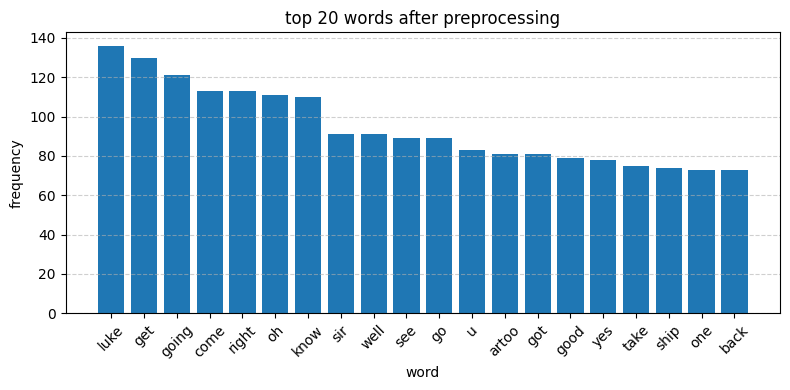

In [8]:
#  frequency distribution of preprocessed words

all_tokens = [token for row in df_all['new_script'] for token in row]
freq_dist = Counter(all_tokens).most_common(20)
words, counts = zip(*freq_dist)

plt.figure(figsize=(8, 4))
plt.bar(words, counts)
plt.title("top 20 words after preprocessing")
plt.xlabel("word")
plt.ylabel("frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


These are the most common words once we’ve removed stopwords and lemmatized. Notice character names like “luke” still appear often, along with verbs such as “get,” “going,” and “know,” since those convey more meaningful information after cleaning.


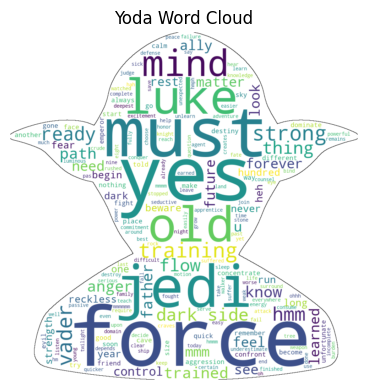

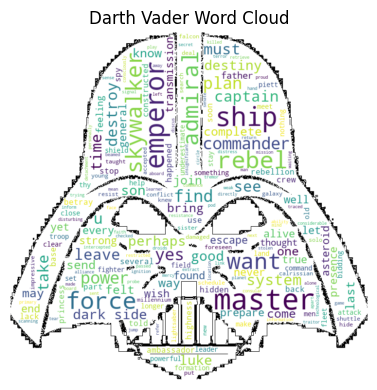

In [9]:

# 1. set full paths to your mask images (use exact filenames)
yoda_mask_path  = r"C:\Users\woofy\Downloads\Lab4_dataset\wordcloud_masks\yoda.png"
vader_mask_path = r"C:\Users\woofy\Downloads\Lab4_dataset\wordcloud_masks\vader.jpg"

# 2. load each mask as a NumPy array
yoda_mask  = np.array(Image.open(yoda_mask_path))
vader_mask = np.array(Image.open(vader_mask_path))

# 3. helper to gather all tokens for a given character
def get_text_for(name):
    rows = df_all[df_all['character'].str.upper() == name.upper()]
    return " ".join(" ".join(tokens) for tokens in rows['new_script'])

# 4. function to draw a masked word cloud
def plot_wordcloud(text, title, mask_array):
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        mask=mask_array,
        contour_width=1,        # optional outline
        contour_color="black"   # outline color
    ).generate(text)
    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

# 5. generate and display the masked clouds
yoda_text  = get_text_for("YODA")
vader_text = get_text_for("VADER")

plot_wordcloud(yoda_text,  "Yoda Word Cloud",  yoda_mask)
plot_wordcloud(vader_text, "Darth Vader Word Cloud", vader_mask)



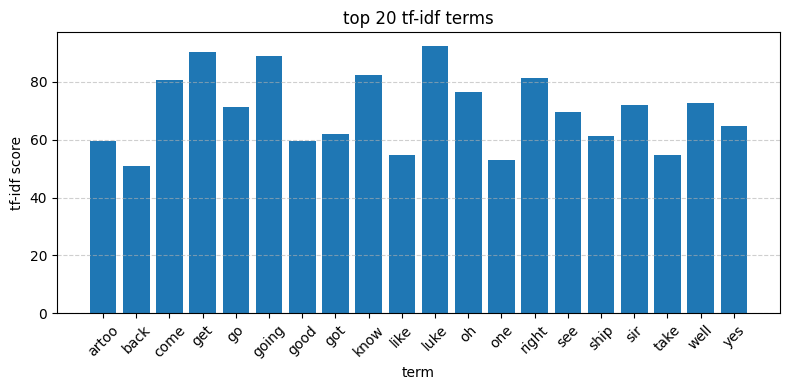

In [10]:
#  tf-idf analysis

df_all['clean_text'] = df_all['new_script'].apply(lambda tokens: " ".join(tokens))
vectorizer = TfidfVectorizer(max_features=20)
tfidf_matrix = vectorizer.fit_transform(df_all['clean_text'])
tfidf_sums = tfidf_matrix.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()

plt.figure(figsize=(8, 4))
plt.bar(terms, tfidf_sums)
plt.title("top 20 tf-idf terms")
plt.xlabel("term")
plt.ylabel("tf-idf score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


These terms have the highest TF-IDF scores, meaning they stand out as most distinctive across all dialogue lines. Words like “luke,” “right,” and “know” are especially important because they occur frequently in some contexts but not uniformly across every line.


C:\Users\woofy\AppData\Local\Temp\ipykernel_298580\1978575055.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([light_sent, dark_sent], labels=['light side', 'dark side'])


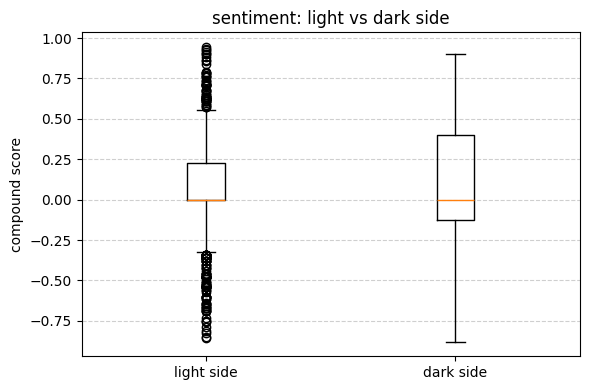

In [11]:
# sentiment analysis with vader

sia = SentimentIntensityAnalyzer()
df_all['sentiment'] = df_all['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

light_chars = ['LUKE', 'YODA', 'LEIA']
dark_chars  = ['VADER', 'EMPEROR', 'BOBA FETT']

light_sent = df_all[df_all['character'].str.upper().isin(light_chars)]['sentiment']
dark_sent  = df_all[df_all['character'].str.upper().isin(dark_chars)]['sentiment']

plt.figure(figsize=(6, 4))
plt.boxplot([light_sent, dark_sent], labels=['light side', 'dark side'])
plt.title("sentiment: light vs dark side")
plt.ylabel("compound score")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# interpretation of Sentiment Analysis

- **Light Side (Luke, Yoda, Leia)*
  - The boxplot shows that most Light Side lines cluster around slightly positive to neutral sentiment scores (near 0.0 to +0.3), with relatively few strongly negative outliers.  
  - This matches the idea that Jedi and Rebel leaders often speak with hope, calm, or encouragement.

- Dark Side (Vader, Emperor, Boba Fett)
  - The Dark Side boxplot has a wider spread, extending deeper into negative sentiment (down to around –0.8). There are also some near‐neutral or mildly positive outliers, but overall the median is lower than for the Light Side.  
  - This aligns with Sith‐sided dialogue being more menacing, angry, or fear‐driven.


most Jedi/Rebel lines fall around neutral or slightly positive sentiment, while Sith/Imperial lines show a wider, more negative spread. This matches the idea that Light Side characters speak with hope, and Dark Side characters speak with anger or madness
